In [1]:
!pip install dtreeviz
!pip install scikit-survival
#!conda install graphviz


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold

import time
from sklearn.model_selection import KFold
from scipy.stats import zscore
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import resample
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from dtreeviz.trees import dtreeviz
colors = [None,  # 0 classes
          None,  # 1 class
          ['#FFF4E5','#D2E3EF'],# 2 classes
           ]

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
           
from IPython.display import Markdown, display
from IPython.display import Image
def printmd(string):
    display(Markdown(string))


# 1) Data Overview & Processing

In [3]:
X = pd.read_csv("NHANESI_X.csv")
y = pd.read_csv('NHANESI_y.csv')

data = X.copy()
data['y']=y['y']
data['death']=[0 if y<0 else 1 for y in data['y']]
data=data[data['y']!=-0]# drop participants that lose contact after examination
#drop missing data in pressures
pressure_columns=['Diastolic BP','Systolic BP','Pulse pressure']
print(data[data[pressure_columns].isnull().all(axis=1)])
data= data[data[pressure_columns].notnull().all(axis=1)].reset_index(drop=True)
data.drop(columns=['Unnamed: 0'],inplace=True)
data.head()

      Unnamed: 0   Age  Diastolic BP  Poverty index  Race  Red blood cells  \
115          115  36.0           NaN          185.0   1.0             77.7   
122          122  70.0           NaN          999.0   1.0             77.7   
125          125  30.0           NaN          155.0   1.0             77.7   
725          725  30.0           NaN          126.0   2.0             41.1   
740          740  29.0           NaN          302.0   2.0             50.0   
751          751  28.0           NaN          539.0   2.0             47.4   
758          758  69.0           NaN          155.0   1.0             40.4   
851          851  74.0           NaN          258.0   1.0             43.6   
1095        1095  28.0           NaN          560.0   1.0             44.6   
1301        1301  30.0           NaN          358.0   2.0             77.7   
1892        1892  47.0           NaN           70.0   2.0             46.0   
1925        1925  55.0           NaN           85.0   2.0       

Age  Diastolic BP  Poverty index  Race  Red blood cells  \
0  35.0          92.0          126.0   2.0             77.7   
1  71.0          78.0          210.0   2.0             77.7   
2  74.0          86.0          999.0   2.0             77.7   
3  64.0          92.0          385.0   1.0             77.7   
4  40.0          78.0          297.0   2.0             77.7   

   Sedimentation rate  Serum Albumin  Serum Cholesterol  Serum Iron  \
0                12.0            5.0              165.0       135.0   
1                37.0            4.0              298.0        89.0   
2                31.0            3.8              222.0       115.0   
3                30.0            4.3              265.0        94.0   
4                24.0            4.0              173.0       121.0   

   Serum Magnesium  Serum Protein  Sex  Systolic BP   TIBC    TS  \
0             1.37            7.6  2.0        142.0  323.0  41.8   
1             1.38            6.4  2.0        156.0  331.0  26.9   
2             1.37            7.4  2.0        170.0  299.0  38.5   
3             1.97            7.3  2.0        172.0  349.0  26.9   
4             1.71            6.7  2.0        118.0  370.0  32.7   

   White blood cells        BMI  Pulse pressure          y  death  
0                5.8  31.109434            50.0  15.274658      1  
1                5.3  32.362572            78.0  11.586073      1  
2                8.1  25.388497            84.0   8.149087      1  
3                6.7  26.446610            80.0 -21.094292      0  
4               10.7  27.217201            40.0 -21.080594      0

In [4]:
dead = data[data["death"] == 1]
alive = data[data["death"] == 0]

In [5]:
dead.describe()

Age  Diastolic BP  Poverty index         Race  Red blood cells  \
count  3448.000000   3448.000000    3448.000000  3448.000000      3448.000000   
mean     63.030162     87.262761     262.135731     1.221868        55.393619   
std      10.531741     14.126823     232.575462     0.433334        14.914189   
min      25.000000     40.000000       4.000000     1.000000        21.400000   
25%      59.000000     80.000000     104.000000     1.000000        45.300000   
50%      67.000000     86.000000     189.000000     1.000000        49.400000   
75%      70.000000     96.000000     330.250000     1.000000        59.000000   
max      74.000000    180.000000     999.000000     3.000000        88.800000   

       Sedimentation rate  Serum Albumin  Serum Cholesterol   Serum Iron  \
count         3119.000000    3448.000000        3448.000000  3448.000000   
mean            19.167361       4.289820         234.469983   100.304234   
std             12.850358       0.328588          51.677303    36.507050   
min              1.000000       2.700000          75.000000    20.000000   
25%              9.000000       4.100000         201.000000    75.000000   
50%             17.000000       4.300000         231.550000    95.000000   
75%             27.000000       4.500000         265.000000   120.000000   
max             66.000000       5.600000         691.000000   396.000000   

       Serum Magnesium  Serum Protein          Sex  Systolic BP         TIBC  \
count      3448.000000    3448.000000  3448.000000  3448.000000  3448.000000   
mean          1.681012       7.118619     1.465777   148.628190   350.067285   
std           0.155381       0.536020     0.498900    26.652277    53.736283   
min           0.860000       4.400000     1.000000    80.000000   147.000000   
25%           1.590000       6.800000     1.000000   130.000000   314.000000   
50%           1.685000       7.100000     1.000000   146.000000   346.000000   
75%           1.780000       7.400000     2.000000   164.000000   382.000000   
max           2.500000      11.500000     2.000000   270.000000   607.000000   

                TS  White blood cells          BMI  Pulse pressure  \
count  3448.000000        3031.000000  3448.000000     3448.000000   
mean     29.258469           7.503035    26.179821       61.365429   
std      11.396862           2.466939     5.295822       20.747613   
min       4.200000           2.900000    12.585333       12.000000   
25%      21.700000           5.900000    22.592970       46.000000   
50%      27.550000           7.200000    25.671280       60.000000   
75%      35.000000           8.700000    28.946006       74.000000   
max     100.000000          56.000000    72.218113      170.000000   

                 y   death  
count  3448.000000  3448.0  
mean     10.843402     1.0  
std       5.595762     0.0  
min       0.016438     1.0  
25%       6.268493     1.0  
50%      11.342922     1.0  
75%      15.528938     1.0  
max      21.471461     1.0

In [6]:
alive.describe()

Age  Diastolic BP  Poverty index         Race  Red blood cells  \
count  6046.000000   6046.000000    6046.000000  6046.000000      6046.000000   
mean     42.533907     81.259014     302.344029     1.170857        54.575504   
std      13.216643     12.229284     214.506340     0.404790        14.427224   
min      25.000000     25.000000       2.000000     1.000000        25.500000   
25%      31.000000     72.000000     155.000000     1.000000        44.900000   
50%      40.000000     80.000000     254.000000     1.000000        48.700000   
75%      51.000000     90.000000     385.000000     1.000000        56.400000   
max      74.000000    170.000000     999.000000     3.000000        88.800000   

       Sedimentation rate  Serum Albumin  Serum Cholesterol   Serum Iron  \
count         5578.000000    6046.000000        6046.000000  6046.000000   
mean            14.639297       4.408237         214.692772   101.621237   
std             10.328114       0.322693          46.976251    37.205256   
min              1.000000       2.900000          53.000000    17.000000   
25%              7.000000       4.200000         182.000000    76.000000   
50%             12.000000       4.400000         210.000000    97.000000   
75%             20.000000       4.600000         242.000000   123.000000   
max             72.000000       5.700000         793.000000   325.000000   

       Serum Magnesium  Serum Protein          Sex  Systolic BP         TIBC  \
count      6046.000000    6046.000000  6046.000000  6046.000000  6046.000000   
mean          1.682703       7.086057     1.681442   127.689878   368.455342   
std           0.140737       0.488504     0.465956    20.350955    60.112634   
min           0.820000       4.700000     1.000000    80.000000   112.000000   
25%           1.600000       6.800000     1.000000   114.000000   327.000000   
50%           1.680000       7.100000     2.000000   124.000000   361.000000   
75%           1.770000       7.400000     2.000000   140.000000   400.000000   
max           2.890000       9.900000     2.000000   270.000000   717.000000   

                TS  White blood cells          BMI  Pulse pressure  \
count  6046.000000        5453.000000  6046.000000     6046.000000   
mean     28.248660           7.416340    25.402101       46.430863   
std      11.023063           2.146852     4.932276       14.276512   
min       3.200000           2.100000    14.227712       10.000000   
25%      20.800000           6.000000    21.937407       37.000000   
50%      27.100000           7.200000    24.633396       44.000000   
75%      34.400000           8.500000    27.885696       54.000000   
max     100.000000          51.200000    58.818811      150.000000   

                 y   death  
count  6046.000000  6046.0  
mean    -19.502624     0.0  
std       1.744760     0.0  
min     -22.058676     0.0  
25%     -20.608847     0.0  
50%     -19.913927     0.0  
75%     -18.913927     0.0  
max      -7.411187     0.0

In [7]:
print(data.columns)
predictors=['Age', 'Diastolic BP', 'Poverty index', 'Race', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure']
noncategorical_predictors=['Age', 'Diastolic BP', 'Poverty index', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure']
x_train,x_val,y_train,y_val = train_test_split(data[predictors],data[['y','death']],train_size=0.7, random_state=1)
print(x_train)
print(y_train)
x_train.reset_index(drop=True,inplace=True)
x_val.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)
# standardization
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_noncategorical=x_train.drop(columns=['Sex','Race'])
x_val_noncategorical=x_val.drop(columns=['Sex','Race'])
scaler.fit(x_train_noncategorical)
standardized_x_train= pd.DataFrame(data=scaler.transform(x_train_noncategorical), columns=noncategorical_predictors)
standardized_x_train['Sex']=x_train['Sex']
standardized_x_train['Race']=x_train['Race']
standardized_x_val= pd.DataFrame(data=scaler.transform(x_val_noncategorical), columns=noncategorical_predictors)
standardized_x_val['Sex']=x_val['Sex']
standardized_x_val['Race']=x_val['Race']
print(standardized_x_train.isnull().sum())
print(standardized_x_val.isnull().sum())

Index(['Age', 'Diastolic BP', 'Poverty index', 'Race', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure', 'y',
       'death'],
      dtype='object')
       Age  Diastolic BP  Poverty index  Race  Red blood cells  \
7904  38.0          68.0          221.0   3.0             46.7   
4744  30.0          60.0           98.0   1.0             43.0   
3178  38.0          88.0          998.0   1.0             48.1   
927   57.0          80.0          999.0   2.0             46.3   
195   70.0          80.0          265.0   1.0             77.7   
...    ...           ...            ...   ...              ...   
2895  45.0          90.0          104.0   1.0             44.1   
7813  50.0          85.0          238.0   1.0             53.3   
905   74.0          94.0          208.0   1.0             49.4   
5192  42.

In [8]:
#KNN imputer for Sedimentation rate and White blood cells
knn_imputer=KNNImputer(n_neighbors=2)
knn_imputer.fit(standardized_x_train)
standardized_x_train_imputed=pd.DataFrame(data=knn_imputer.transform(standardized_x_train),columns=list(standardized_x_train.columns))
standardized_x_val_imputed=pd.DataFrame(data=knn_imputer.transform(standardized_x_val),columns=list(standardized_x_val.columns))
standardized_X_imputed=pd.DataFrame(data=np.concatenate([standardized_x_train_imputed.values, standardized_x_val_imputed.values], axis=0),columns=list(standardized_x_val.columns))
y=pd.DataFrame(data=np.concatenate([y_train.values, y_val.values], axis=0),columns=['y','death'])
cleaned_data= standardized_X_imputed.copy()
cleaned_data['y']=y['y']
cleaned_data['death']=y['death']
X_train, X_test, y_train, y_test = standardized_x_train_imputed, standardized_x_val_imputed, y_train, y_val
y_train_class = y_train["death"]
y_test_class = y_test["death"]
y_train_val = y_train["y"]
y_test_val = y_test["y"]

In [9]:
cleaned_data.head()

Age  Diastolic BP  Poverty index  Red blood cells  Sedimentation rate  \
0 -0.759925     -1.150340      -0.298666        -0.555731           -0.273051   
1 -1.268725     -1.748095      -0.855198        -0.808927            2.253755   
2 -0.759925      0.344046       3.216987        -0.459927           -0.273051   
3  0.448473     -0.253708       3.221511        -0.583104            2.602280   
4  1.275271     -0.253708      -0.099582         1.565643            0.859655   

   Serum Albumin  Serum Cholesterol  Serum Iron  Serum Magnesium  \
0       0.407840          -1.130353   -0.356368        -0.287328   
1      -0.496631          -0.044293   -1.256225         0.396150   
2       1.312311           0.398175   -0.792663         0.191106   
3      -1.099612           0.277502   -0.601784         0.942932   
4      -1.099612           2.449621   -0.274563         2.378235   

   Serum Protein  Systolic BP      TIBC        TS  White blood cells  \
0      -0.574847    -1.716210 -1.547248  0.351734           0.146027   
1       1.388484     0.349217  0.595489 -1.319382           0.923822   
2       0.799485    -0.524618  0.085313 -0.807266          -0.761400   
3       0.406819    -0.286299 -0.169774 -0.555700          -0.156448   
4      -0.182181     0.190338 -0.084745 -0.277181           0.405292   

        BMI  Pulse pressure  Sex  Race          y  death  
0 -0.952550       -1.506847  2.0   3.0 -18.928767    0.0  
1  2.153560        1.743881  2.0   1.0 -19.825114    0.0  
2  0.083657       -0.965059  1.0   1.0 -21.077854    0.0  
3  1.695012       -0.206556  2.0   2.0  16.199543    1.0  
4 -0.151657        0.443589  2.0   1.0 -21.616210    0.0

# 2) EDA 

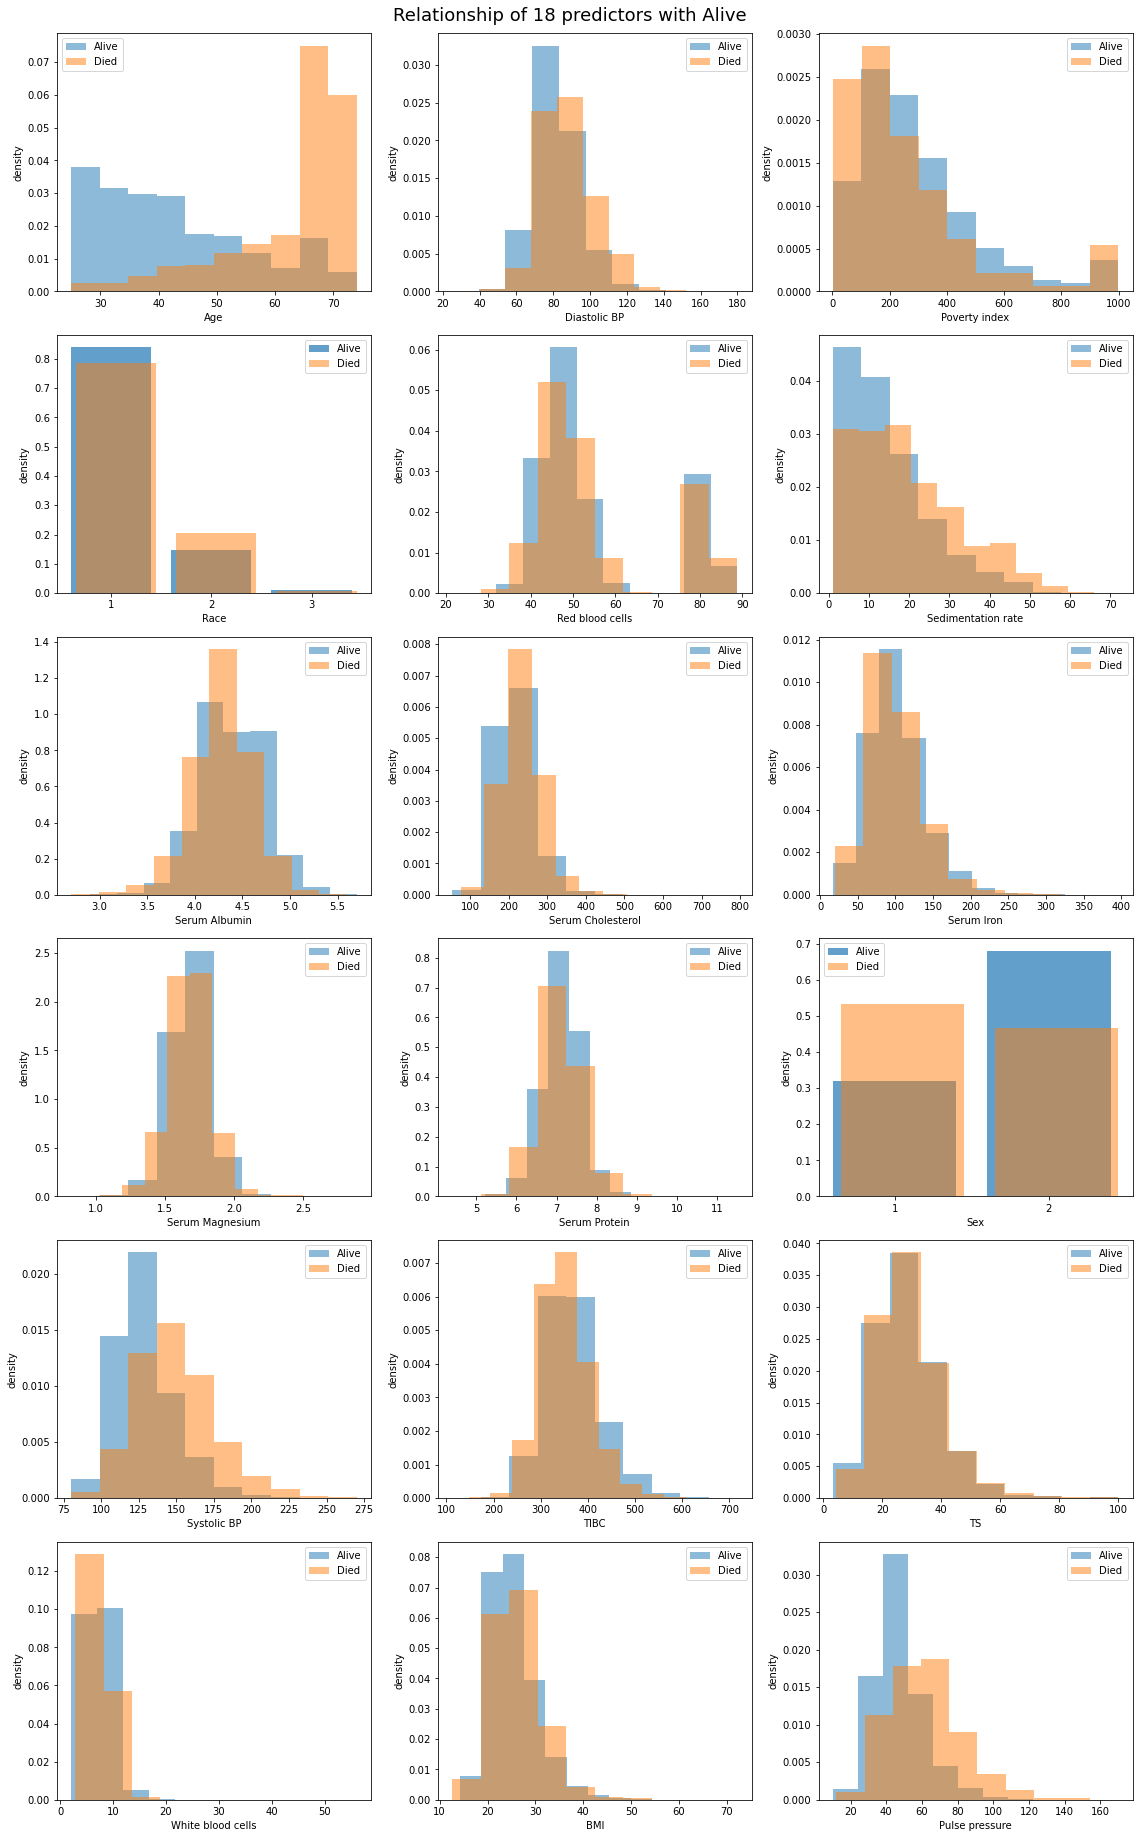

In [10]:
alive_yes = data[data['death']==0]
alive_no = data[data['death']==1]

cols = ['Age', 'Diastolic BP', 'Poverty index', 'Race',
       'Red blood cells', 'Sedimentation rate', 'Serum Albumin',
       'Serum Cholesterol', 'Serum Iron', 'Serum Magnesium', 'Serum Protein',
       'Sex', 'Systolic BP', 'TIBC', 'TS', 'White blood cells', 'BMI',
       'Pulse pressure']

fig, axes = plt.subplots(6, 3, figsize=(16,26))
axes = axes.ravel()
for c, ax in zip(cols, axes):
    if c in ('Diastolic BP', 'Age', 'Poverty index', 'Red blood cells','Sedimentation rate', 'Serum Albumin',
       'Serum Cholesterol', 'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Systolic BP', 'TIBC', 'TS', 
       'White blood cells', 'BMI','Pulse pressure'):
        ax.hist(alive_yes[c], alpha=0.5, label='Alive', density=True)
        ax.hist(alive_no[c], alpha=0.5, label='Died', density=True)
        ax.set_ylabel('density')
    else:
        prop_yes = alive_yes[c].dropna().value_counts().sort_index()/sum(alive_yes[c].dropna().value_counts().sort_index())
        prop_no = alive_no[c].dropna().value_counts().sort_index()/sum(alive_no[c].dropna().value_counts().sort_index())
        ax.bar(sorted(alive_yes[c].dropna().unique()), prop_yes, alpha=0.7, label='Alive',)
        ax.bar(sorted(alive_no[c].dropna().unique()+0.05), prop_no, alpha=0.5, label='Died')
        ax.set_ylabel('density')
        ax.set_xticks(alive_yes[c].dropna().unique())
    
    ax.set_xlabel(c)
    ax.legend()
    
plt.suptitle('Relationship of 18 predictors with Alive \n', fontsize=18)
plt.tight_layout()
plt.savefig("predictors.png")

Age  Diastolic BP  Poverty index  Red blood cells  \
min -1.586724     -4.363272      -1.289565        -2.287045   
max  1.529671      7.218225       3.221511         2.325231   

     Sedimentation rate  Serum Albumin  Serum Cholesterol  Serum Iron  \
min           -1.318626      -5.018987          -3.403033   -2.292424   
max            4.867693       4.025725          11.480004    8.042295   

     Serum Magnesium  Serum Protein  Systolic BP      TIBC        TS  \
min        -5.891845      -5.286839    -2.192847 -4.251178 -2.280722   
max         8.256142       8.652806     5.353906  6.037361  6.416265   

     White blood cells       BMI  Pulse pressure  Sex  Race  
min          -2.316989 -2.585738       -2.265351  1.0   1.0  
max          20.973642  9.240036        6.403258  2.0   3.0

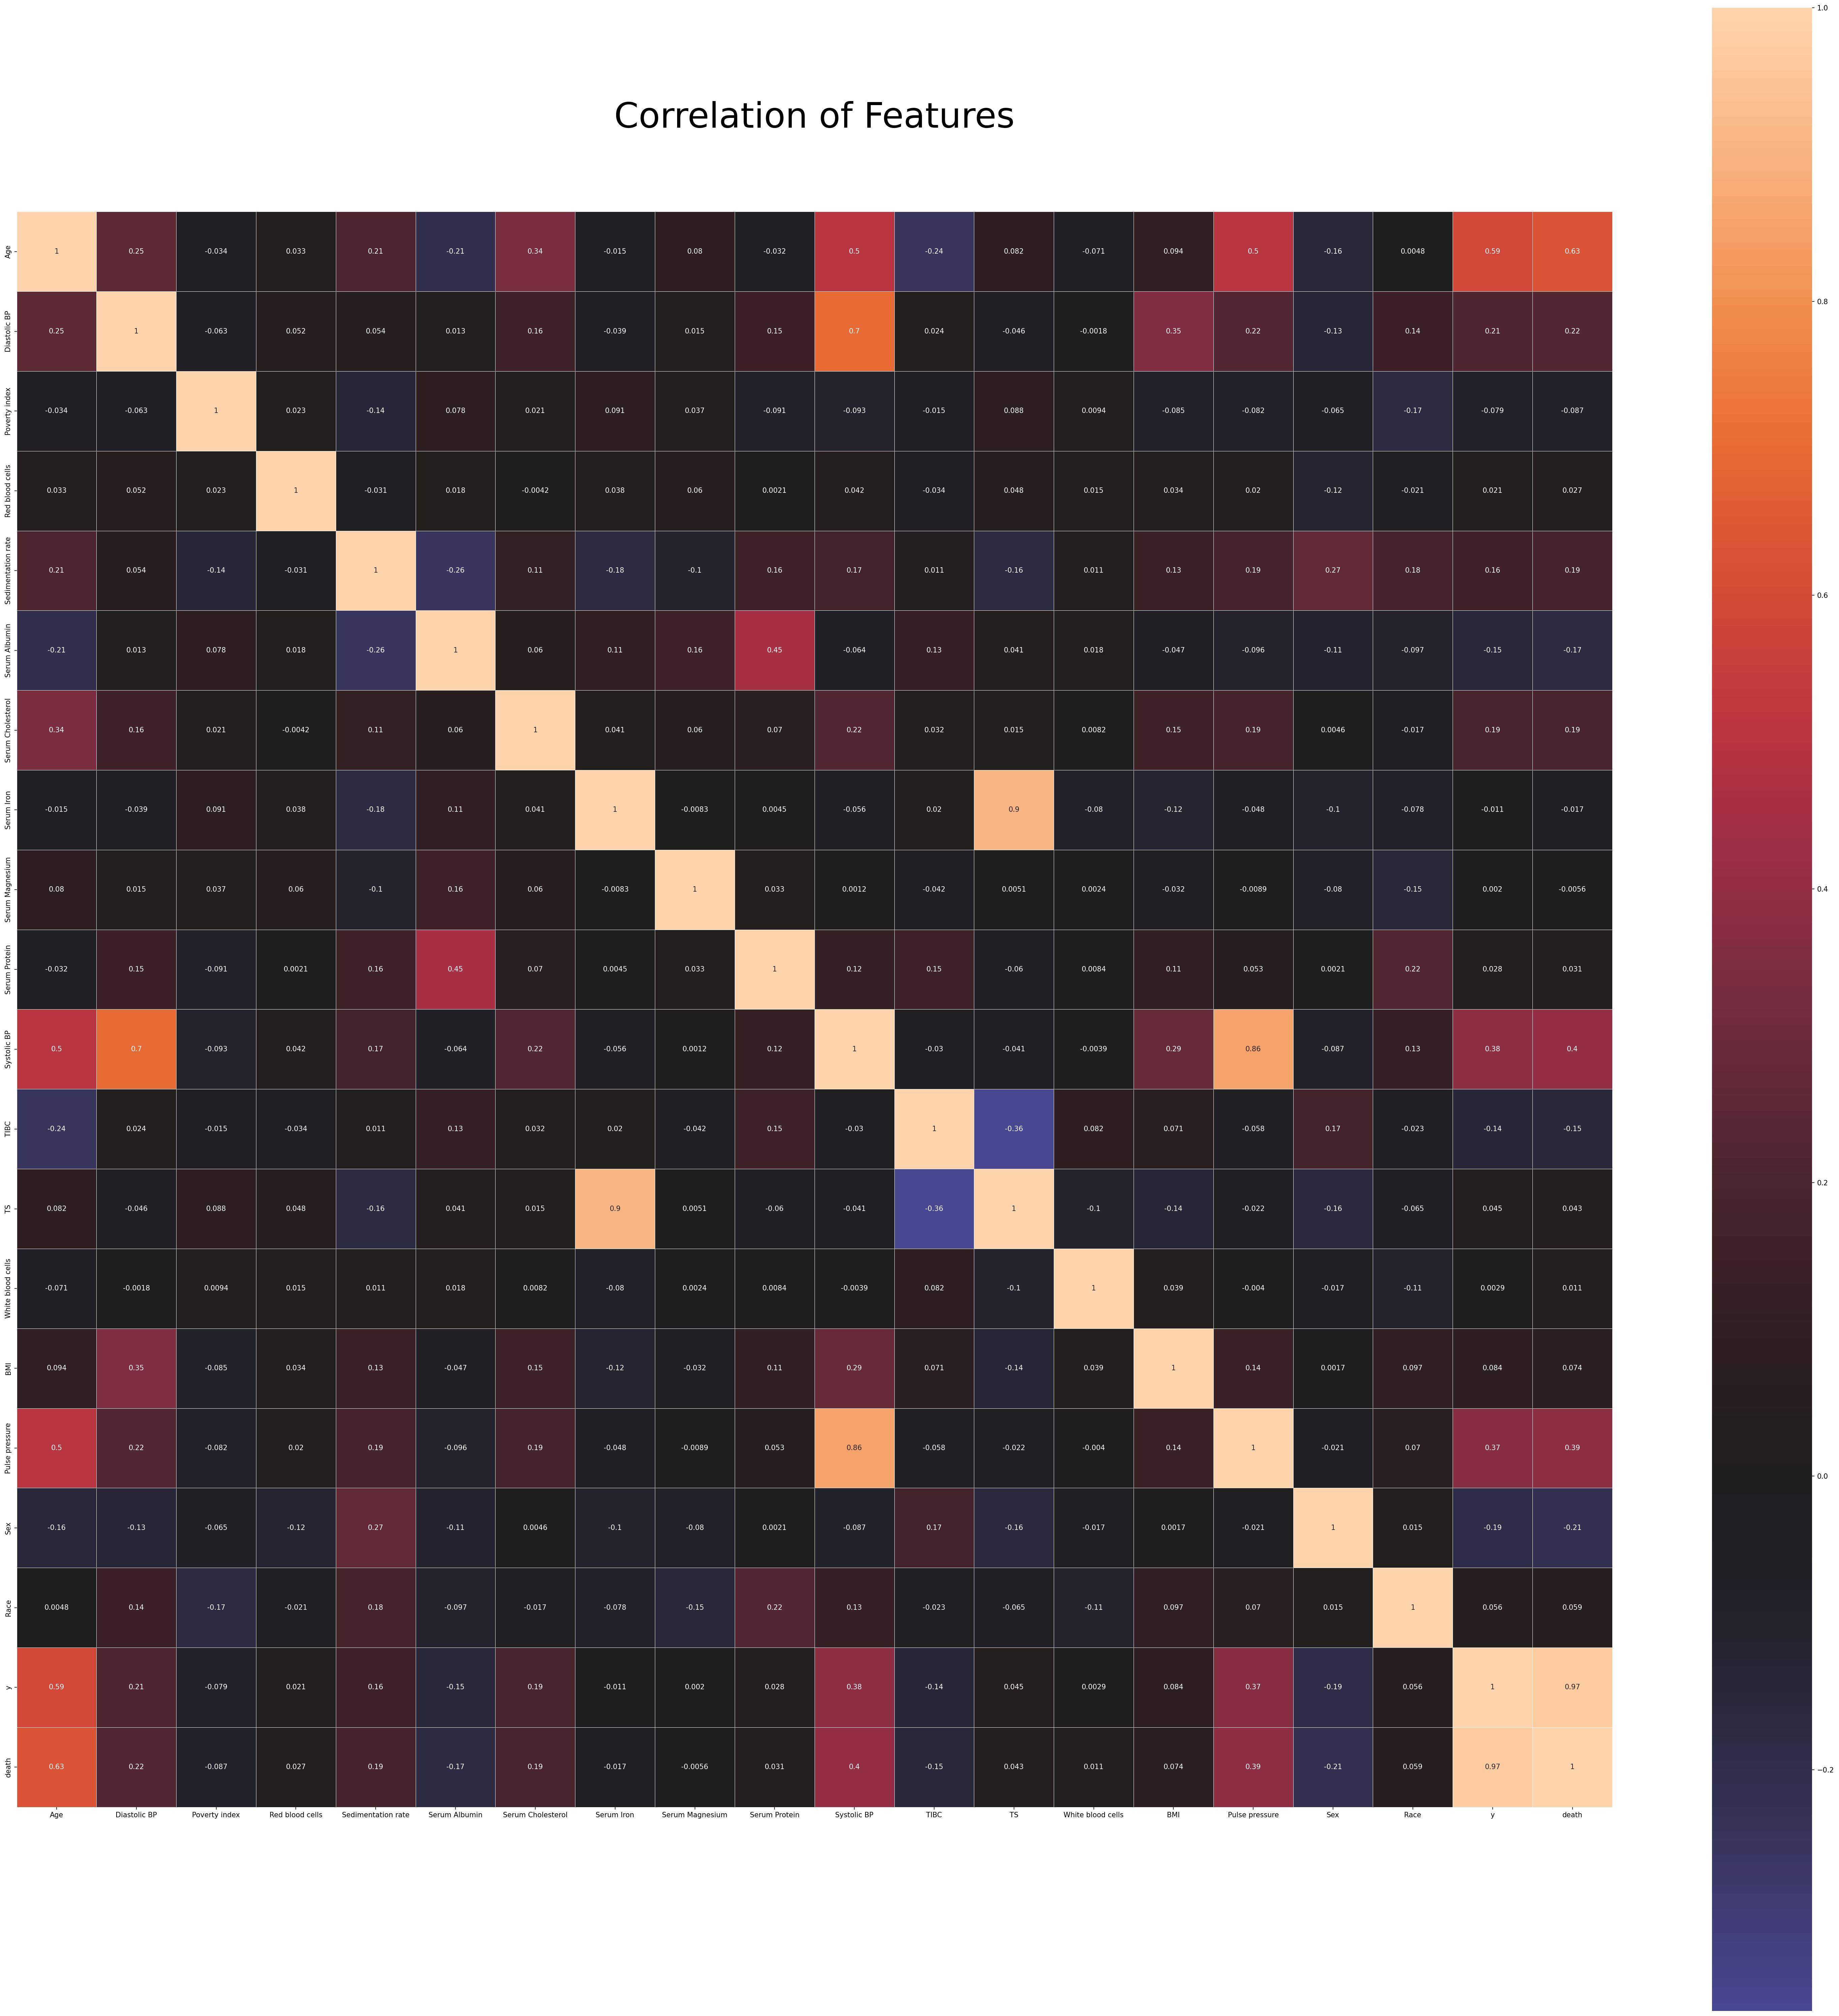

In [11]:
# heatmap
plt.figure(figsize=(40,40), dpi=150)
plt.title('Correlation of Features',y=1.05,fontsize=50)
sns.heatmap(cleaned_data.corr(),linewidths=0.3,vmax=1.0,square=True,linecolor='white',annot=True,center=0)
plt.tight_layout()
plt.savefig('heat_map.png')
standardized_X_imputed.describe().loc[['min','max']]

# 3) Method

## 3.1) Baseline

In [12]:
#baseline for regression
lreg=LinearRegression()
lreg.fit(X_train,y_train_val)
y_val_pred = lreg.predict(X_test)
print("Regression Train MSE: ", mean_squared_error(y_train_val,lreg.predict(X_train)))
print("Regression Test MSE: ", mean_squared_error(y_test_val,y_val_pred))

Regression Train MSE:  139.1363534324669
Regression Test MSE:  141.52411111473884


In [13]:
#baseline for classification
logreg_c = LogisticRegression(random_state=1)
logreg_c.fit(X_train, y_train_class)
logreg_accuracy = logreg_c.score(X_test, y_test_class)
print("logistic Train accuracy: ", logreg_c.score(X_train, y_train_class))
print("logistic Test accuracy: ", logreg_accuracy)

logistic Train accuracy:  0.8299473288186606
logistic Test accuracy:  0.8192348192348192


## 3.2) Baseline with Polynomial Features

In [14]:
#linear regression with polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
maxdeg = 5
test_mses=[]
for i in range(maxdeg):
    X_train_poly=PolynomialFeatures(i+1,include_bias=False).fit_transform(X_train)
    X_test_poly=PolynomialFeatures(i+1,include_bias=False).fit_transform(X_test)
    lreg=LinearRegression(fit_intercept=True)
    lreg.fit(X_train_poly,y_train_val)
    y_test_pred=lreg.predict(X_test_poly)
    vmse=mean_squared_error(y_test_val,y_test_pred)
    test_mses.append(vmse)
best_degree= np.argmin(test_mses)+1
best_degree

2

In [15]:
X_train_poly=PolynomialFeatures(2,include_bias=False).fit_transform(X_train)
X_test_poly=PolynomialFeatures(2,include_bias=False).fit_transform(X_test)
lreg=LinearRegression(fit_intercept=True)
lreg.fit(X_train_poly,y_train_val)
y_test_pred=lreg.predict(X_test_poly)
y_train_pred=lreg.predict(X_train_poly)
vmse=mean_squared_error(y_test_val,y_test_pred)
tmse=mean_squared_error(y_train_val,y_train_pred)
vmse

139.81519654807957

In [16]:
#logistic regression with polynomial features
maxdeg = 5
test_class_scores=[]
y_train_class=y_train['death']
y_test_class=y_test['death']
for i in range(maxdeg):
    X_train_poly=PolynomialFeatures(i+1,include_bias=False).fit_transform(X_train)
    X_test_poly=PolynomialFeatures(i+1,include_bias=False).fit_transform(X_test)
    logreg=LogisticRegression(fit_intercept=True)
    logreg.fit(X_train_poly,y_train_class)
    y_test_pred=logreg.predict(X_test_poly)
    score=logreg.score(X_test_poly,y_test_class)
    test_class_scores.append(score)
best_degree_class= np.argmax(test_class_scores)+1
best_degree_class

/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

2

In [17]:
test_class_scores[1]

0.8259038259038259

## 3.3) Regularization models

In [18]:
# Lasso regression
from sklearn.linear_model import Lasso, LassoCV
alphas=[10**(-5),10**(-4),10**(-3),10**(-2),10**(-1)]
X_train_poly=PolynomialFeatures(2,include_bias=False).fit_transform(X_train)
X_test_poly=PolynomialFeatures(2,include_bias=False).fit_transform(X_test)
lassoCV=LassoCV(alphas=alphas,max_iter=10000,cv=10).fit(X_train_poly,y_train_val)
lassoCV_val_mses_mean=np.mean(lassoCV.mse_path_,axis=1)
best_alpha=lassoCV.alpha_
best_alpha

/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150899.76547653502, tolerance: 134.6489500513969
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 359014.2846303666, tolerance: 134.6489500513969
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106425.66394661431, tolerance: 135.62678572537456
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/si

0.1

In [19]:
lasso = Lasso(alpha=best_alpha)
print(X_train_poly.shape)
lasso.fit(X_train_poly, y_train_val)
y_test_pred_reg=lasso.predict(X_test_poly)
y_train_pred_reg=lasso.predict(X_train_poly)
print(mean_squared_error(y_train_val,y_train_pred_reg))
b=[]
non_zero_b=[]
print(mean_squared_error(y_test_val, y_test_pred_reg))
print('The coefficients are:')
print('Beta0 :',lasso.intercept_)
for i in range(188):
    b.append(lasso.coef_[i+1])
    if abs(lasso.coef_[i+1])>1:
        non_zero_b.append(lasso.coef_[i+1])
    print("Beta"+str(i+1),":",lasso.coef_[i])
predictors=X_train.columns
len(non_zero_b)
print(predictors[10])

(6645, 189)
132.12168053262272
138.09333561196013
The coefficients are:
Beta0 : -8.603637328934713
Beta1 : 7.816392179701335
Beta2 : 0.0
Beta3 : -0.5266928313109506
Beta4 : -0.0
Beta5 : 0.0
Beta6 : -0.4975776075159486
Beta7 : 0.15193547892021594
Beta8 : -0.0
Beta9 : -0.0
Beta10 : 0.0
Beta11 : 1.040146573378236
Beta12 : 0.0
Beta13 : -0.136318539066219
Beta14 : 0.530771378842959
Beta15 : -0.0
Beta16 : 0.0
Beta17 : -0.0
Beta18 : 0.0
Beta19 : 2.4038860190398257
Beta20 : 0.0
Beta21 : 0.07833072560674274
Beta22 : 0.19157724617587224
Beta23 : 0.0
Beta24 : 0.05934787573486568
Beta25 : 0.0
Beta26 : 0.0
Beta27 : 0.0
Beta28 : -0.05301374374563918
Beta29 : 0.0
Beta30 : 0.06563995534247606
Beta31 : -0.0
Beta32 : 0.03684006583935117
Beta33 : 0.22259886262908032
Beta34 : 0.0
Beta35 : -0.0
Beta36 : -0.0
Beta37 : 0.29731269728387166
Beta38 : -0.11099400793224164
Beta39 : 0.0
Beta40 : -0.0
Beta41 : -0.0
Beta42 : 0.17426389492914052
Beta43 : 0.0
Beta44 : -0.1138375319548055
Beta45 : -0.0
Beta46 : 0.0
Bet

In [20]:
#Ridge regression
from sklearn.linear_model import Ridge, RidgeCV
alphas=[10**(-5),10**(-4),10**(-3),10**(-2),10**(-1)]
X_train_poly=PolynomialFeatures(2,include_bias=False).fit_transform(X_train)
X_test_poly=PolynomialFeatures(2,include_bias=False).fit_transform(X_test)
ridgeCV=RidgeCV(alphas=alphas).fit(X_train_poly,y_train_val)
ridgeCV.alpha_

0.1

In [21]:
ridge = Ridge(alpha=0.1)
b_r=[]
ridge.fit(X_train_poly, y_train_val)
y_test_pred_reg=ridge.predict(X_test_poly)
y_train_pred_reg=ridge.predict(X_train_poly)
print(mean_squared_error(y_train_val,y_train_pred_reg))
print(mean_squared_error(y_test_val, y_test_pred_reg))
print('The coefficients are:')
print('Beta0 :',ridge.intercept_)
for i in range(188):
    if abs(ridge.coef_[i+1])>0.1:
        b_r.append(ridge.coef_[i+1])
    print("Beta"+str(i+1),":",ridge.coef_[i])


129.84284707523764
139.80932807664337
The coefficients are:
Beta0 : -13.054045054041492
Beta1 : 10.30220311277067
Beta2 : 0.8345865893258289
Beta3 : -1.4244560922789873
Beta4 : -0.8968912895756067
Beta5 : -0.016338848539409766
Beta6 : -0.4291618805386438
Beta7 : 1.3425112432624193
Beta8 : 4.99801024238009
Beta9 : 0.09945597837238422
Beta10 : -0.976196721207784
Beta11 : 0.38312749786542516
Beta12 : -0.7370344671803506
Beta13 : -7.453342672399346
Beta14 : 1.77477299904912
Beta15 : 0.24272221165738794
Beta16 : -0.08256053546603526
Beta17 : -0.4372445199789164
Beta18 : 6.248210359597937
Beta19 : 2.7096923104225796
Beta20 : -0.0988186314155279
Beta21 : 0.11513554452585141
Beta22 : 0.3391947316949841
Beta23 : 0.3790619774802719
Beta24 : 0.412750601804888
Beta25 : -0.1924330031740513
Beta26 : 0.517547539503065
Beta27 : 0.09939554214864862
Beta28 : -0.2673696057875286
Beta29 : -0.09332474203658819
Beta30 : -0.02582504400326332
Beta31 : -0.5658019635480857
Beta32 : 0.1991716797210171
Beta33 : 0

## 3.4) PCA

In [22]:
# Regression 
n_components= [0.85, 0.95, 0.99]
for i in n_components:
    pca = PCA(n_components=i).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    mse = cross_validate(LinearRegression(), X_train_pca, y_train_val, cv=10, scoring=['r2','neg_mean_squared_error'],return_train_score = True)
    train_mse = -1*np.mean(mse['train_neg_mean_squared_error'])
    test_mse = -1*np.mean(mse['test_neg_mean_squared_error'])
    train_r2 = np.mean(mse['train_r2'])
    test_r2 = np.mean(mse['test_r2'])
    print(f"n_components={i}")
    print(f"Cross validation Train MSE is {test_mse}")
    print(f"Cross validation Test MSE is {test_mse}")
    print(f"Cross validation Train R^2: {train_r2:.4f}")
    print(f"Cross validation Test R^2: {test_r2:.4f}")
    print("----------------------------------------")

n_components=0.85
Cross validation Train MSE is 159.5147147912324
Cross validation Test MSE is 159.5147147912324
Cross validation Train R^2: 0.2965
Cross validation Test R^2: 0.2936
----------------------------------------
n_components=0.95
Cross validation Train MSE is 142.91546026812466
Cross validation Test MSE is 142.91546026812466
Cross validation Train R^2: 0.3702
Cross validation Test R^2: 0.3670
----------------------------------------
n_components=0.99
Cross validation Train MSE is 139.8449599188703
Cross validation Test MSE is 139.8449599188703
Cross validation Train R^2: 0.3841
Cross validation Test R^2: 0.3805
----------------------------------------


## 3.5) Decision Tree

In [23]:
depths = np.arange(1, 21)
train_scores = np.array([])
cvmeans = np.array([])
cvstds = np.array([])

for d in depths:
    tree = DecisionTreeClassifier(max_depth = d)
    cv_val = cross_val_score(tree, X_train, y_train_class, cv=5)
    train_scores = np.append(train_scores, tree.fit(X_train, y_train_class).score(X_train, y_train_class))
    cvmeans = np.append(cvmeans, cv_val.mean())
    cvstds = np.append(cvstds, cv_val.std())

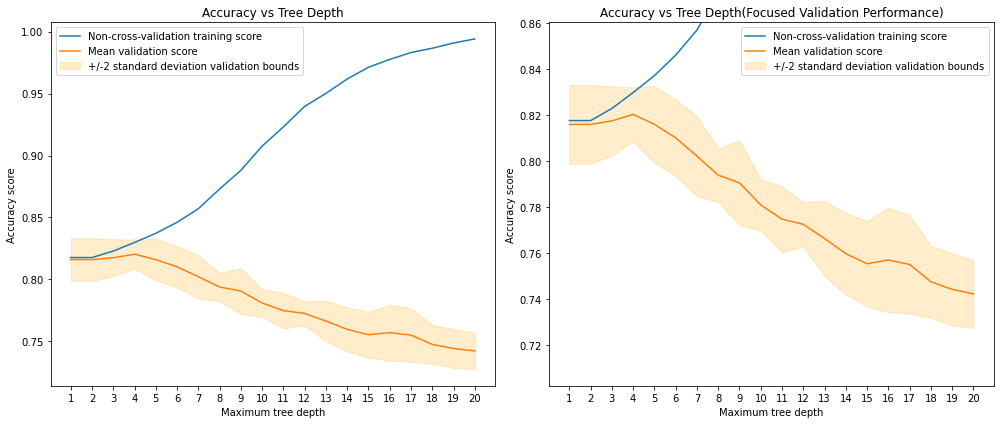

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(14,6))

plt.sca(ax1)
plt.plot(depths, train_scores, label='Non-cross-validation training score')
plt.plot(depths, cvmeans, label='Mean validation score')
plt.fill_between(depths, cvmeans -2 * cvstds, cvmeans + 2 * cvstds, 
                 color = "orange", alpha=0.2, label='+/-2 standard deviation validation bounds')
plt.xticks(depths)
plt.xlabel('Maximum tree depth')
plt.ylabel('Accuracy score')
plt.title('Accuracy vs Tree Depth')
plt.legend()

plt.sca(ax2)
plt.plot(depths, train_scores, label='Non-cross-validation training score')
plt.plot(depths, cvmeans, label='Mean validation score')
plt.fill_between(depths, cvmeans -2 * cvstds, cvmeans + 2 * cvstds, 
                 color = "orange", alpha=0.2, label='+/-2 standard deviation validation bounds')
plt.xticks(depths)
plt.ylim(min(cvmeans) - 0.04, max(cvmeans) + 0.04)
plt.xlabel('Maximum tree depth')
plt.ylabel('Accuracy score')
plt.title('Accuracy vs Tree Depth(Focused Validation Performance)')
plt.legend()

plt.tight_layout()

In [25]:
best_cv_depth = np.argmax(cvmeans) + 1
print(f"Best cross validation depth is: {best_cv_depth}")
best_tree = DecisionTreeClassifier(max_depth=best_cv_depth).fit(X_train, y_train_class)
best_cv_tree_train_score = best_tree.score(X_train, y_train_class)
best_cv_tree_test_score = best_tree.score(X_test, y_test_class)
# print model results summary
print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

Best cross validation depth is: 4
The tree of max-depth 4 trained on the full training set, achieves the following accuracy scores:

	train	0.8298
	TEST	0.8185


## 3.6) AdaBoosting

In [26]:
X_train80, X_val, y_train80, y_val = train_test_split(X_train,
                                                      y_train_class,
                                                      train_size=.8,
                                                      random_state=109,
                                                      stratify=y_train_class)

In [27]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                         n_estimators=800, learning_rate=0.05, algorithm='SAMME.R').fit(X_train80, y_train80)
ada_train_score = list(ada.staged_score(X_train80, y_train80))
ada_test_score = list(ada.staged_score(X_val, y_val))

/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


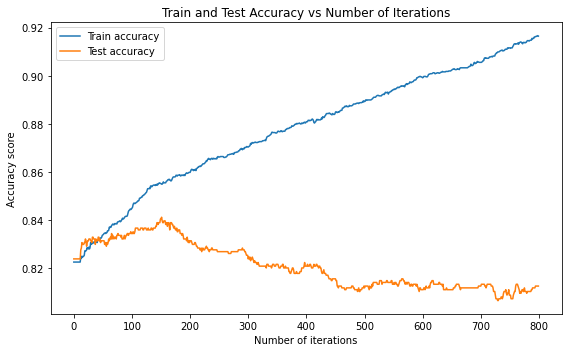

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(ada_train_score, label='Train accuracy')
plt.plot(ada_test_score, label='Test accuracy')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy score')
plt.title('Train and Test Accuracy vs Number of Iterations')
plt.tight_layout()

In [29]:
ada_train_scores = []
ada_test_scores = []
for depth in range(1,5):
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), 
                         n_estimators=800, learning_rate=0.05, algorithm='SAMME.R').fit(X_train80, y_train80)
    ada_train_scores.append(list(ada.staged_score(X_train80, y_train80)))
    ada_test_scores.append(list(ada.staged_score(X_val, y_val)))

/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/User

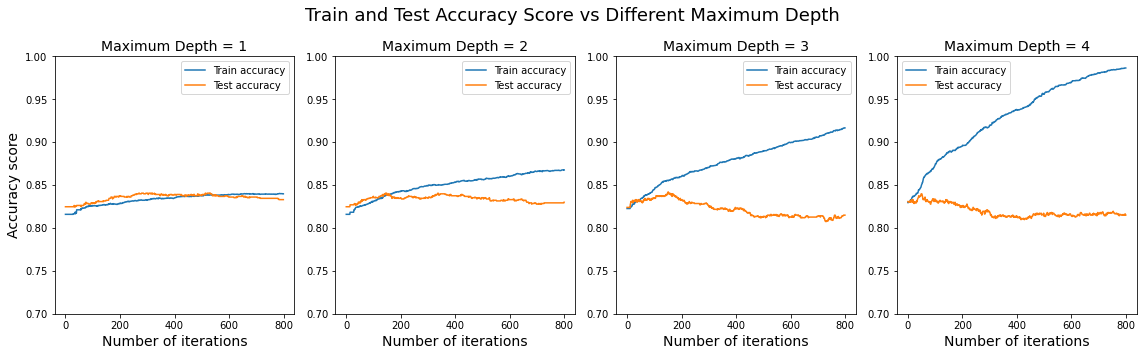

In [30]:
fig, ax = plt.subplots(1,4, figsize =(16,5))
for i in np.arange(4):
    plt.sca(ax[i])
    plt.plot(ada_train_scores[i], label='Train accuracy')
    plt.plot(ada_test_scores[i], label='Test accuracy')
    plt.legend()
    plt.ylim(0.7, 1.0)
    plt.xlabel('Number of iterations', fontsize = 14)
    plt.title(f'Maximum Depth = {i+1}', fontsize = 14)
    if i == 0 :
        plt.ylabel('Accuracy score', fontsize = 14)
plt.suptitle("Train and Test Accuracy Score vs Different Maximum Depth", fontsize = 18)
plt.tight_layout()

In [31]:
for i in range(4):
    print(f"Test accuracy of AdaBoost with maximum depth {i+1} is {max(ada_test_scores[i])}")
print(f"Test accuracy of depth 2 reached the highest score at iteration {np.argmax(ada_test_scores[1]) + 1}")

Test accuracy of AdaBoost with maximum depth 1 is 0.8404815650865313
Test accuracy of AdaBoost with maximum depth 2 is 0.8404815650865313
Test accuracy of AdaBoost with maximum depth 3 is 0.8419864559819413
Test accuracy of AdaBoost with maximum depth 4 is 0.8397291196388262
Test accuracy of depth 2 reached the highest score at iteration 145


In [32]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), 
                         n_estimators=144, learning_rate=0.05, algorithm='SAMME.R').fit(X_train, y_train_class)
ada_train_acc = ada.score(X_train, y_train_class)
ada_test_acc = ada.score(X_test, y_test_class)
print(f"Ada Boost Train Accuracy: {ada_train_acc:.2%}")
print(f"Ada Boost Test Accuracy: {ada_test_acc:.2%}")

Ada Boost Train Accuracy: 83.69%
Ada Boost Test Accuracy: 82.27%


## 3.7) Random Forest

In [33]:
grid_values = {'max_features': ["sqrt", "log2"],
                'min_samples_split': [50,100, 200,500,1000,2000],
                'n_estimators': [100],
                'random_state': [88]}
tic = time.time()
rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid=grid_values, cv=5,n_jobs=-1)
rf_cv.fit(X_train, y_train_class)
toc = time.time()
print('time:', round(toc-tic, 2),'s')

time: 6.49 s


In [34]:
train_y_pred_class = rf_cv.predict(X_train)
test_y_pred_class = rf_cv.predict(X_test)
cm = confusion_matrix(y_test_class, test_y_pred_class)
print ("Confusion Matrix: \n", cm)
print ("\n Train Accuracy:", accuracy_score(y_train_class, train_y_pred_class))
print ("\n Test Accuracy:", accuracy_score(y_test_class, test_y_pred_class))
print ("\nTPR:", recall_score(y_test_class, test_y_pred_class))
print(f"Best parameter: {rf_cv.best_params_}")

Confusion Matrix: 
 [[1543  265]
 [ 232  809]]

 Train Accuracy: 0.8642588412340105

 Test Accuracy: 0.8255528255528255

TPR: 0.777137367915466
Best parameter: {'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 100, 'random_state': 88}


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

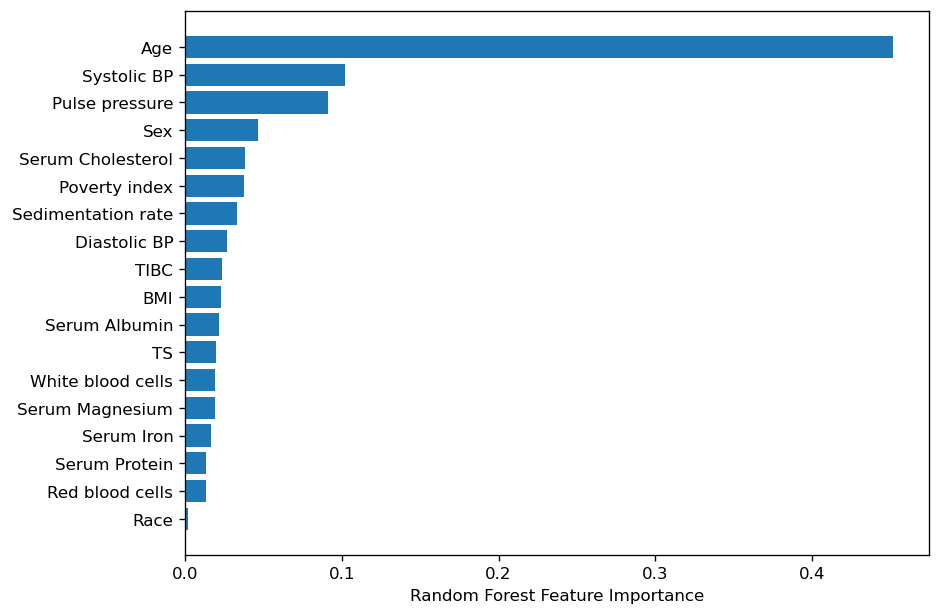

In [35]:
#feature importance
rf_c = RandomForestClassifier(max_features='sqrt', min_samples_split=50,n_estimators=100, random_state=88)
rf_c.fit(X_train, y_train_class)
plt.figure(figsize=(8, 6), dpi=120)
sorted_idx = rf_c.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf_c.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout

In [36]:
# Selecting two trees at random
forestvati1 = rf_c.estimators_[0]
forestvati2 = rf_c.estimators_[50]

In [37]:
# draw forestvati1 tree
vizC = dtreeviz(forestvati1, X_train,y_train_class,
               feature_names = X_train.columns,
               target_name = 'Death', class_names= ['No','Yes']
              ,orientation = 'TD',
               colors={'classes':colors},
               label_fontsize=14,
               ticks_fontsize=10,
                scale=1.1
               )
printmd('<center> <h2> <i> Random Forest Tree 1 </h2> </center>')
vizC

<center> <h2> <i> Random Forest Tree 1 </h2> </center>

## 3.8) Neural Network

In [38]:
kf5 = KFold(n_splits=5, shuffle=True, random_state = 42)
i = 1
acc = []
for train_index, test_index in kf5.split(X_train):
    x_train1 = X_train.iloc[train_index]
    x_test1 = X_train.iloc[test_index]
    y_train1 = y_train_class.iloc[train_index]
    y_test1 = y_train_class.iloc[test_index]
        
    #Train the model
    clf = MLPClassifier(hidden_layer_sizes=(60,60) , solver = "lbfgs",activation='logistic', max_iter= 60,random_state= 23)
    clf.fit(x_train1, y_train1)  
    
    y_pred_train = clf.predict(x_train1)
    print('The accuracy of this prediction is', accuracy_score(y_train1, y_pred_train))

    y_pred_test = clf.predict(x_test1)
    print('Accuracy on test is', accuracy_score(y_test1, y_pred_test))
    
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, y_pred_test)}")
    acc.append(accuracy_score(y_test1, y_pred_test))
    i += 1
print(f"mean accuracy : {np.mean(acc)}")

/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


The accuracy of this prediction is 0.8401053423626788
Accuracy on test is 0.8239277652370203
Accuracy for the fold no. 1 on the test set: 0.8239277652370203


/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


The accuracy of this prediction is 0.8408577878103838
Accuracy on test is 0.8171557562076749
Accuracy for the fold no. 2 on the test set: 0.8171557562076749


/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


The accuracy of this prediction is 0.8419864559819413
Accuracy on test is 0.8209179834462002
Accuracy for the fold no. 3 on the test set: 0.8209179834462002


/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


The accuracy of this prediction is 0.8348382242287434
Accuracy on test is 0.8510158013544018
Accuracy for the fold no. 4 on the test set: 0.8510158013544018
The accuracy of this prediction is 0.8355906696764485
Accuracy on test is 0.8389766741911211
Accuracy for the fold no. 5 on the test set: 0.8389766741911211
mean accuracy : 0.8303987960872836


/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [39]:
clf = MLPClassifier(hidden_layer_sizes=(60,60) , solver = "lbfgs",activation='logistic', max_iter= 60, random_state= 23)
clf.fit(X_train, y_train_class) 
y_pred_train = clf.predict(X_train)
print('The accuracy of this prediction is', accuracy_score(y_train_class, y_pred_train))

y_pred_test = clf.predict(X_test)
print('Accuracy on test is', accuracy_score(y_test_class, y_pred_test))

The accuracy of this prediction is 0.8356659142212189
Accuracy on test is 0.828009828009828


/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## 3.9) Survival Analysis

### Data processing

In [40]:
# Transform the y data to expected format
def transform_y_data(dataset, col_event, col_time):
    # Convert time to possitive number
    dataset[col_time] = dataset[col_time].abs()
    # Convert death to boolean
    dataset[col_event] = dataset[col_event].astype('bool')
    # Create strctured array
    y = np.empty(dtype=[(col_event, bool), (col_time, np.float64)], shape=dataset.shape[0])
    y[col_event] = dataset[col_event].values
    y[col_time] = dataset[col_time].values
    
    return y
y_train_t = transform_y_data(y_train, 'death', 'y')
y_test_t = transform_y_data(y_test, 'death', 'y')

### Cox model

In [41]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train_t)

/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=1.15899e-30): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=2.28517e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:445: LinAlgWarning: Ill-conditioned matrix (rcond=5.82298e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


CoxPHSurvivalAnalysis()

In [42]:
from sksurv.metrics import concordance_index_censored

# prediction = estimator.predict(X_test)
# result = concordance_index_censored(y_test['death'], y_test["y"], prediction)
# result[0]
train_score = estimator.score(X_train, y_train_t)
test_score = estimator.score(X_test, y_test_t)
print(f"Training score: {train_score}\nTesting score: {test_score}")

Training score: 0.8233456809474397
Testing score: 0.823389032848106


In [43]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_train.values, y_train_t)
pd.Series(scores, index=X_train.columns).sort_values(ascending=False)

Age                   0.799099
Systolic BP           0.690418
Pulse pressure        0.678792
Diastolic BP          0.601812
Sex                   0.593331
Serum Cholesterol     0.590240
Serum Albumin         0.588442
Poverty index         0.580137
Sedimentation rate    0.576029
TIBC                  0.569529
BMI                   0.527871
Race                  0.517827
Red blood cells       0.516085
Serum Iron            0.515371
TS                    0.512556
White blood cells     0.511133
Serum Protein         0.508155
Serum Magnesium       0.505441
dtype: float64

### Ridge

In [44]:
X = X_train
y = y_train_t
Xt = OneHotEncoder().fit_transform(X)
Xt.round(2).head()

Age  Diastolic BP  Poverty index  Red blood cells  Sedimentation rate  \
0 -0.76         -1.15          -0.30            -0.56               -0.27   
1 -1.27         -1.75          -0.86            -0.81                2.25   
2 -0.76          0.34           3.22            -0.46               -0.27   
3  0.45         -0.25           3.22            -0.58                2.60   
4  1.28         -0.25          -0.10             1.57                0.86   

   Serum Albumin  Serum Cholesterol  Serum Iron  Serum Magnesium  \
0           0.41              -1.13       -0.36            -0.29   
1          -0.50              -0.04       -1.26             0.40   
2           1.31               0.40       -0.79             0.19   
3          -1.10               0.28       -0.60             0.94   
4          -1.10               2.45       -0.27             2.38   

   Serum Protein  Systolic BP  TIBC    TS  White blood cells   BMI  \
0          -0.57        -1.72 -1.55  0.35               0.15 -0.95   
1           1.39         0.35  0.60 -1.32               0.92  2.15   
2           0.80        -0.52  0.09 -0.81              -0.76  0.08   
3           0.41        -0.29 -0.17 -0.56              -0.16  1.70   
4          -0.18         0.19 -0.08 -0.28               0.41 -0.15   

   Pulse pressure  Sex  Race  
0           -1.51  2.0   3.0  
1            1.74  2.0   1.0  
2           -0.97  1.0   1.0  
3           -0.21  2.0   2.0  
4            0.44  2.0   1.0

In [45]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

In [46]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

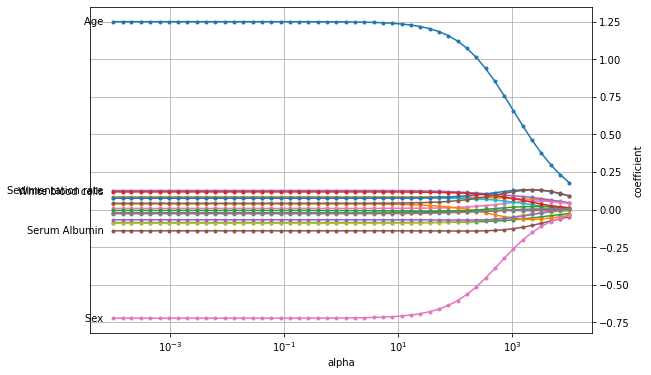

In [47]:
plot_coefficients(coefficients, n_highlight=5)

In [48]:
train_score = cph.score(X_train, y_train_t)
test_score = cph.score(X_test, y_test_t)
print(f"Training score: {train_score}\nTesting score: {test_score}")

Training score: 0.7909015477836793
Testing score: 0.7953757335568935


### Lasso

In [49]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

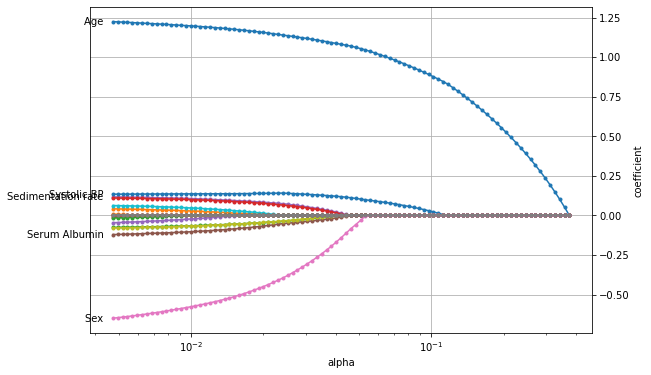

In [50]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=Xt.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)

In [51]:
train_score = cox_lasso.score(X_train, y_train_t)
test_score = cox_lasso.score(X_test, y_test_t)
print(f"Training score: {train_score}\nTesting score: {test_score}")

Training score: 0.822673473396414
Testing score: 0.8231556283819831


### Elastic Net

In [52]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

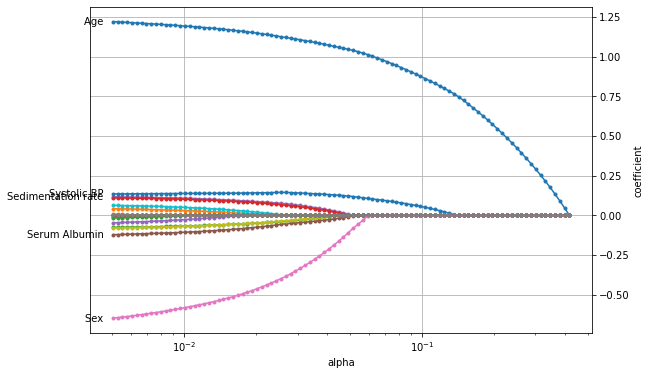

In [53]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=Xt.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [54]:
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
#warnings.simplefilter("ignore", UserWarning)
#warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [55]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/ruqiliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Best alpha: 0.0072827292


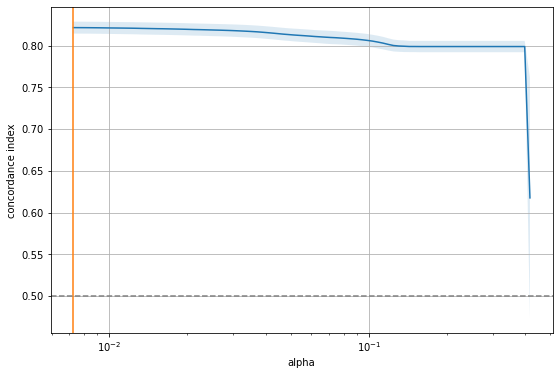

In [56]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)
print("Best alpha: {:.10f}".format(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0]))

Number of non-zero coefficients: 14


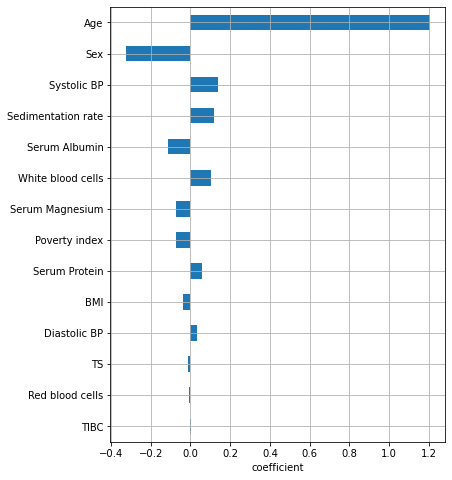

In [57]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xt.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [58]:
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.007282729241566136],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [59]:
train_score = coxnet_pred.score(X_train, y_train_t)
test_score = coxnet_pred.score(X_test, y_test_t)
print(f"Training score: {train_score}\nTesting score: {test_score}")

Training score: 0.8225001438460668
Testing score: 0.8231811772938592


### Random Survival Forest

In [60]:
random_state = 20

rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train_t)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [61]:
rsf.score(X_test, y_test_t)

0.8249890875834021

In [62]:
X_test_sel = X_test.loc[np.random.choice(len(X_test), size=7, replace=False)]

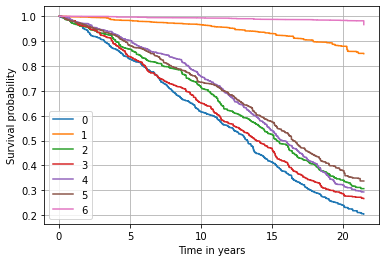

In [63]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in years")
plt.legend()
plt.grid(True)

In [64]:
rsf.score(X_train, y_train_t)

0.8715398671854384